# CNN Experiment: Real vs Fake Faces
This notebook implements the training and evaluation of a ResNet18 model for binary classification (Real vs Fake faces).
It covers three scenarios:
1. Training from Scratch
2. Linear Probing (Frozen backbone)
3. Fine-tuning (Unfrozen pretrained backbone)

In [23]:
import time
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from tqdm.notebook import tqdm # Use the specific notebook widget
import numpy as np
import matplotlib.pyplot as plt

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Set seed
torch.manual_seed(0)
np.random.seed(0)

Using MPS (Apple Silicon GPU)


In [24]:
class ResNet18(nn.Module):
    def __init__(self, pretrained=False, probing=False):
        super(ResNet18, self).__init__()
        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            self.transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
            self.resnet18 = resnet18(weights=weights)
        else:
            self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])            
            self.resnet18 = resnet18()
                
        
        in_features_dim = self.resnet18.fc.in_features        
        self.resnet18.fc = nn.Identity()
        if probing:
            # Freeze all parameters
            for name, param in self.resnet18.named_parameters():
                    param.requires_grad = False
        
        # This layer is always trainable
        self.logistic_regression = nn.Linear(in_features_dim, 1)

    def forward(self, x):
        features = self.resnet18(x)
        # Output raw logits
        return self.logistic_regression(features)

def get_loaders(path, transform, batch_size):
    """
    Get the data loaders for the train, validation and test sets.
    """
    train_path = os.path.join(path, 'train')
    val_path = os.path.join(path, 'val')
    test_path = os.path.join(path, 'test')

    # Check if paths exist
    if not os.path.exists(train_path):
        print(f"Error: {train_path} does not exist.")
        return None, None, None

    train_set = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
    val_set = torchvision.datasets.ImageFolder(root=val_path, transform=transform)
    test_set = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True if device.type != 'cpu' else False)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True if device.type != 'cpu' else False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True if device.type != 'cpu' else False)
    return train_loader, val_loader, test_loader

In [25]:
def compute_accuracy(model, data_loader, device,criterion=None):
    """
    Compute the accuracy of the model on the data in data_loader
    """
    model.eval()
    total_correct = 0.0
    total_samples = 0
    losses = 0.0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            predictions = model(batch_X)
            if criterion is not None:
                loss = criterion(predictions, batch_y.float().unsqueeze(1))
                losses += loss.item() * batch_y.size(0)
            predictions = model(batch_X) # Shape: [Batch_Size, 1]
            # Threshold at 0: logits > 0 is class 1 (Real), else class 0 (Fake)
            predicted_labels = (predictions.squeeze() > 0).float() 
            total_correct += (predicted_labels == batch_y).sum().item()
            total_samples += batch_y.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    return accuracy, losses / total_samples if total_samples > 0 else 0

def run_training_epoch(model, criterion, optimizer, train_loader, device):
    """
    Run a single training epoch
    """
    model.train()
    total_loss = 0.0
    
    # Using tqdm.notebook for nicer progress bar
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for (imgs, labels) in progress_bar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(imgs)
        # Reshape labels to match predictions [Batch, 1]
        loss = criterion(predictions, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'batch_loss': loss.item()})
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def train_and_evaluate(model, train_loader, val_loader, test_loader, epochs=5, lr=0.0001):
    model = model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = np.inf
    best_val_acc = 0.0
    best_model_state_dict = None
    train_losses = []
    val_accs = []
    
    print(f"Starting training on {device}...")
    
    for epoch in range(epochs):
        start_time = time.time()
        # Train
        avg_train_loss = run_training_epoch(model, criterion, optimizer, train_loader, device)
        train_losses.append(avg_train_loss)
        # Validation
        val_acc, val_loss = compute_accuracy(model, val_loader, device, criterion)
        val_accs.append(val_acc)
        if (val_loss < best_val_loss):
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state_dict = model.to('cpu').state_dict()
            model = model.to(device)
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {epoch_time:.1f}s")
        
    # Final Test
    test_acc, test_loss = compute_accuracy(model, test_loader, device, criterion)
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    
    return train_losses, val_accs, best_model_state_dict

In [14]:
# # How to load the model back (Uncomment to use after restart)
model_scratch = ResNet18(pretrained=False, probing=False)
if os.path.exists('model_scratch_checkpoint.pth'):
    model_scratch.load_state_dict(torch.load('model_scratch_checkpoint.pth', map_location=device))
    print("Model loaded successfully!")
model_scratch = model_scratch.to(device)
BATCH_SIZE = 36
LEARNING_RATE = 0.001
EPOCHS = 25  # Set to 1 for testing time per epoch as requested
DATA_PATH = 'whichfaceisreal' # Ensure this folder is in the root
transform_scratch = model_scratch.transform
train_loader, val_loader, test_loader = get_loaders(DATA_PATH, transform_scratch, BATCH_SIZE)


Model loaded successfully!


In [26]:
if train_loader:
    print(f"Resuming training for {EPOCHS} epochs with LR={LEARNING_RATE}...")
    train_losses_scratch, val_accs_scratch, best_model_scratch_state_dict = train_and_evaluate(model_scratch, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE)
    model_scratch.load_state_dict(best_model_scratch_state_dict)
    torch.save(best_model_scratch_state_dict, 'model_scratch_checkpoint.pth')
    print("Model checkpoint saved as 'model_scratch_checkpoint.pth'")
else:
    print("Could not load data. Check path.")

Resuming training for 25 epochs with LR=0.001...
Starting training on mps...


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1/25 | Loss: 0.5304 | Val Acc: 0.6050 | Time: 34.6s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2/25 | Loss: 0.4432 | Val Acc: 0.6400 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/25 | Loss: 0.3511 | Val Acc: 0.6550 | Time: 34.0s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/25 | Loss: 0.2822 | Val Acc: 0.6700 | Time: 34.0s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/25 | Loss: 0.2150 | Val Acc: 0.6800 | Time: 34.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6/25 | Loss: 0.2031 | Val Acc: 0.6650 | Time: 35.3s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7/25 | Loss: 0.1420 | Val Acc: 0.7100 | Time: 34.0s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8/25 | Loss: 0.1193 | Val Acc: 0.7150 | Time: 34.5s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9/25 | Loss: 0.1076 | Val Acc: 0.7100 | Time: 33.8s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/25 | Loss: 0.0975 | Val Acc: 0.7250 | Time: 33.9s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 11/25 | Loss: 0.0553 | Val Acc: 0.7300 | Time: 33.7s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 12/25 | Loss: 0.0469 | Val Acc: 0.7050 | Time: 35.0s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 13/25 | Loss: 0.1022 | Val Acc: 0.7450 | Time: 34.3s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 14/25 | Loss: 0.0714 | Val Acc: 0.7250 | Time: 34.8s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 15/25 | Loss: 0.0628 | Val Acc: 0.6700 | Time: 34.5s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 16/25 | Loss: 0.0527 | Val Acc: 0.7300 | Time: 34.5s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 17/25 | Loss: 0.0258 | Val Acc: 0.7300 | Time: 34.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 18/25 | Loss: 0.0122 | Val Acc: 0.7300 | Time: 34.3s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 19/25 | Loss: 0.0096 | Val Acc: 0.7200 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 20/25 | Loss: 0.0059 | Val Acc: 0.7100 | Time: 34.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 21/25 | Loss: 0.0048 | Val Acc: 0.7450 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 22/25 | Loss: 0.0020 | Val Acc: 0.7250 | Time: 34.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 23/25 | Loss: 0.0017 | Val Acc: 0.7300 | Time: 34.3s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 24/25 | Loss: 0.0066 | Val Acc: 0.7500 | Time: 34.9s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 25/25 | Loss: 0.0065 | Val Acc: 0.7250 | Time: 34.6s

Final Test Accuracy: 0.7625
Model checkpoint saved as 'model_scratch_checkpoint.pth'


In [27]:
# --- Task 1: Resume Training From Scratch ---
print("=== Task 1: Resuming Training ===")

# Set a lower learning rate for fine-tuning/continuation
# Original was 0.0001. Try 10x smaller to be safe.

NEW_LEARNING_RATE = 0.0001 
MORE_EPOCHS = 25
model_scratch = model_scratch.to(device)
if train_loader:
    print(f"Resuming training for {MORE_EPOCHS} epochs with LR={NEW_LEARNING_RATE}...")
    train_losses_scratch, val_accs_scratch, best_model_scratch_state_dict = train_and_evaluate(model_scratch, train_loader, val_loader, test_loader, epochs=MORE_EPOCHS, lr=NEW_LEARNING_RATE)
    model_scratch.load_state_dict(best_model_scratch_state_dict)
    torch.save(best_model_scratch_state_dict, 'model_scratch_checkpoint.pth')
    print("Model checkpoint saved as 'model_scratch_checkpoint.pth'")
else:
    print("Could not load data. Check path.")
try:
    model_scratch.load_state_dict(torch.load('model_finetune_checkpoint.pth', map_location=device))
    model_scratch = model_scratch.to(device)
    transform_scratch = model_scratch.transform()
except:
    model_scratch = ResNet18(pretrained=False, probing=False)

=== Task 1: Resuming Training ===
Resuming training for 25 epochs with LR=0.0001...
Starting training on mps...


Training:   0%|          | 0/39 [00:00<?, ?it/s]

/Users/omrimelcer/Documents/university/2026_fall/IML/ex4/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/25 | Loss: 0.2795 | Val Acc: 0.7150 | Time: 35.3s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2/25 | Loss: 0.1310 | Val Acc: 0.7200 | Time: 34.7s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/25 | Loss: 0.0567 | Val Acc: 0.7300 | Time: 38.6s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/25 | Loss: 0.0266 | Val Acc: 0.7300 | Time: 35.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/25 | Loss: 0.0127 | Val Acc: 0.7350 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6/25 | Loss: 0.0090 | Val Acc: 0.7350 | Time: 34.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7/25 | Loss: 0.0056 | Val Acc: 0.7350 | Time: 34.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8/25 | Loss: 0.0039 | Val Acc: 0.7200 | Time: 35.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9/25 | Loss: 0.0036 | Val Acc: 0.7150 | Time: 36.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/25 | Loss: 0.0031 | Val Acc: 0.7250 | Time: 36.9s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 11/25 | Loss: 0.0019 | Val Acc: 0.7250 | Time: 34.7s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 12/25 | Loss: 0.0017 | Val Acc: 0.7300 | Time: 34.5s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 13/25 | Loss: 0.0015 | Val Acc: 0.7400 | Time: 34.5s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 14/25 | Loss: 0.0029 | Val Acc: 0.7400 | Time: 34.8s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 15/25 | Loss: 0.0018 | Val Acc: 0.7500 | Time: 34.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 16/25 | Loss: 0.0011 | Val Acc: 0.7200 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 17/25 | Loss: 0.0067 | Val Acc: 0.7300 | Time: 34.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 18/25 | Loss: 0.0421 | Val Acc: 0.7050 | Time: 34.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 19/25 | Loss: 0.0499 | Val Acc: 0.7400 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 20/25 | Loss: 0.0247 | Val Acc: 0.7150 | Time: 34.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 21/25 | Loss: 0.0108 | Val Acc: 0.7050 | Time: 34.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 22/25 | Loss: 0.0059 | Val Acc: 0.7300 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 23/25 | Loss: 0.0035 | Val Acc: 0.7350 | Time: 34.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 24/25 | Loss: 0.0042 | Val Acc: 0.7250 | Time: 34.3s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 25/25 | Loss: 0.0041 | Val Acc: 0.7450 | Time: 34.3s

Final Test Accuracy: 0.7750
Model checkpoint saved as 'model_scratch_checkpoint.pth'


In [28]:
# --- Task 2: Linear Probing ---
# Only trains the final logistic regression layer, backbone is frozen
print("=== Task 2: Linear Probing ===")
EPOCHS = 15  
model_probing = ResNet18(pretrained=True, probing=True)
transform_probing = model_probing.transform

train_loader, val_loader, test_loader = get_loaders(DATA_PATH, transform_probing, BATCH_SIZE)

if train_loader:
    train_losses, val_accs, best_model_state_dict = train_and_evaluate(model_probing, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE)

=== Task 2: Linear Probing ===
Starting training on mps...


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1/15 | Loss: 0.6599 | Val Acc: 0.6200 | Time: 29.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2/15 | Loss: 0.5795 | Val Acc: 0.6450 | Time: 29.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/15 | Loss: 0.5470 | Val Acc: 0.6750 | Time: 29.3s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/15 | Loss: 0.5295 | Val Acc: 0.6850 | Time: 29.0s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/15 | Loss: 0.5183 | Val Acc: 0.6900 | Time: 29.0s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6/15 | Loss: 0.4978 | Val Acc: 0.7050 | Time: 29.4s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7/15 | Loss: 0.4980 | Val Acc: 0.7200 | Time: 29.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8/15 | Loss: 0.4811 | Val Acc: 0.7200 | Time: 29.0s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9/15 | Loss: 0.4857 | Val Acc: 0.7150 | Time: 28.9s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/15 | Loss: 0.4661 | Val Acc: 0.7300 | Time: 28.9s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 11/15 | Loss: 0.4579 | Val Acc: 0.7250 | Time: 29.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 12/15 | Loss: 0.4599 | Val Acc: 0.7350 | Time: 29.1s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 13/15 | Loss: 0.4605 | Val Acc: 0.7300 | Time: 29.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 14/15 | Loss: 0.4680 | Val Acc: 0.7350 | Time: 29.2s


Training:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 15/15 | Loss: 0.4528 | Val Acc: 0.7350 | Time: 29.1s

Final Test Accuracy: 0.7650


In [ ]:
torch.save(model_probing.state_dict(), 'model_probing_checkpoint.pth')
print("Model saved to 'model_probing_checkpoint.pth'")

In [29]:
# --- Task 3: Fine-Tuning ---
# Trains the entire model, but initialized with ImageNet weights
print("=== Task 3: Fine-Tuning ===")
LEARNING_RATE = 0.0001
EPOCHS = 25
model_finetune = ResNet18(pretrained=True, probing=False)
try:
    model_finetune.load_state_dict(torch.load('model_finetune_checkpoint.pth', map_location=device))
    model_finetune = model_finetune.to(device)
    transform_finetune = model_finetune.transform
    print("Loaded fine-tuning checkpoint.")
except:
    print("Starting fine-tuning from ImageNet weights.")
    model_finetune = ResNet18(pretrained=True, probing=False)
    model_finetune = model_finetune.to(device)
    transform_finetune = model_finetune.transform
   
train_loader, val_loader, test_loader = get_loaders(DATA_PATH, transform_finetune, 32)

if train_loader:
    train_and_evaluate(model_finetune, train_loader, val_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE)
torch.save(model_finetune.state_dict(), 'model_finetune_checkpoint.pth')
print("Model saved to 'model_finetune_checkpoint.pth'")

=== Task 3: Fine-Tuning ===
Loaded fine-tuning checkpoint.
Starting training on mps...


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1/25 | Loss: 0.0155 | Val Acc: 0.8800 | Time: 35.2s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2/25 | Loss: 0.0186 | Val Acc: 0.9200 | Time: 34.8s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/25 | Loss: 0.0150 | Val Acc: 0.9150 | Time: 34.9s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4/25 | Loss: 0.0265 | Val Acc: 0.8500 | Time: 34.9s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/25 | Loss: 0.0088 | Val Acc: 0.9050 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 6/25 | Loss: 0.0054 | Val Acc: 0.8900 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7/25 | Loss: 0.0094 | Val Acc: 0.9050 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 8/25 | Loss: 0.0029 | Val Acc: 0.8800 | Time: 35.1s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 9/25 | Loss: 0.0025 | Val Acc: 0.8900 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 10/25 | Loss: 0.0080 | Val Acc: 0.9200 | Time: 35.1s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 11/25 | Loss: 0.0053 | Val Acc: 0.8900 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 12/25 | Loss: 0.0153 | Val Acc: 0.9050 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 13/25 | Loss: 0.0183 | Val Acc: 0.8950 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 14/25 | Loss: 0.0109 | Val Acc: 0.8950 | Time: 35.1s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 15/25 | Loss: 0.0119 | Val Acc: 0.8900 | Time: 35.1s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 16/25 | Loss: 0.0194 | Val Acc: 0.8750 | Time: 34.9s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 17/25 | Loss: 0.0065 | Val Acc: 0.9200 | Time: 35.1s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 18/25 | Loss: 0.0063 | Val Acc: 0.8450 | Time: 34.9s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 19/25 | Loss: 0.0020 | Val Acc: 0.9350 | Time: 35.1s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 20/25 | Loss: 0.0040 | Val Acc: 0.9550 | Time: 34.9s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 21/25 | Loss: 0.0046 | Val Acc: 0.9300 | Time: 34.9s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 22/25 | Loss: 0.0030 | Val Acc: 0.9200 | Time: 35.0s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 23/25 | Loss: 0.0055 | Val Acc: 0.9200 | Time: 34.8s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 24/25 | Loss: 0.0054 | Val Acc: 0.9100 | Time: 34.9s


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 25/25 | Loss: 0.0020 | Val Acc: 0.9300 | Time: 34.9s

Final Test Accuracy: 0.9550
Model saved to 'model_finetune_checkpoint.pth'


Using device: mps
Dataset Classes: ['0_real', '1_fake']
Class Mapping: {0: '0_real', 1: '1_fake'}
Loaded model_scratch_checkpoint.pth
Loaded model_finetune_checkpoint.pth
Scanning test set for examples...
--- Both Correct ---


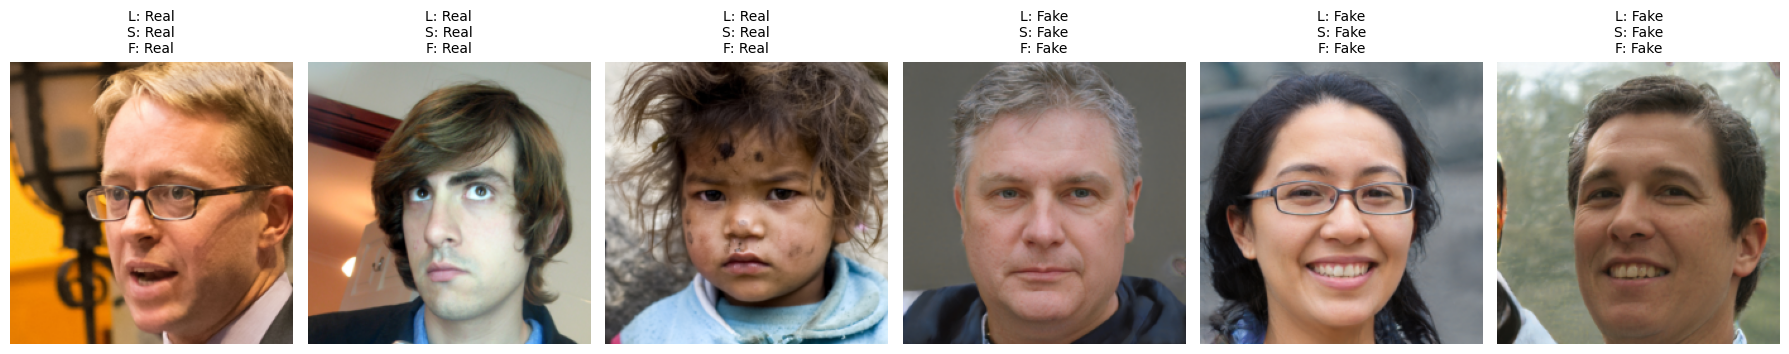

--- Both Wrong ---


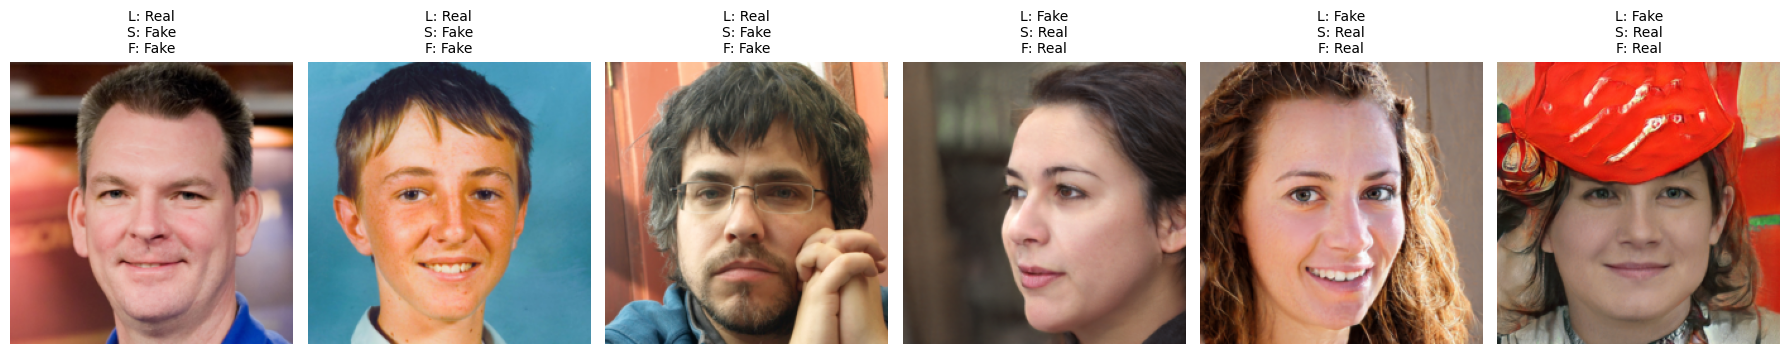

--- Finetune Correct, Scratch Wrong ---


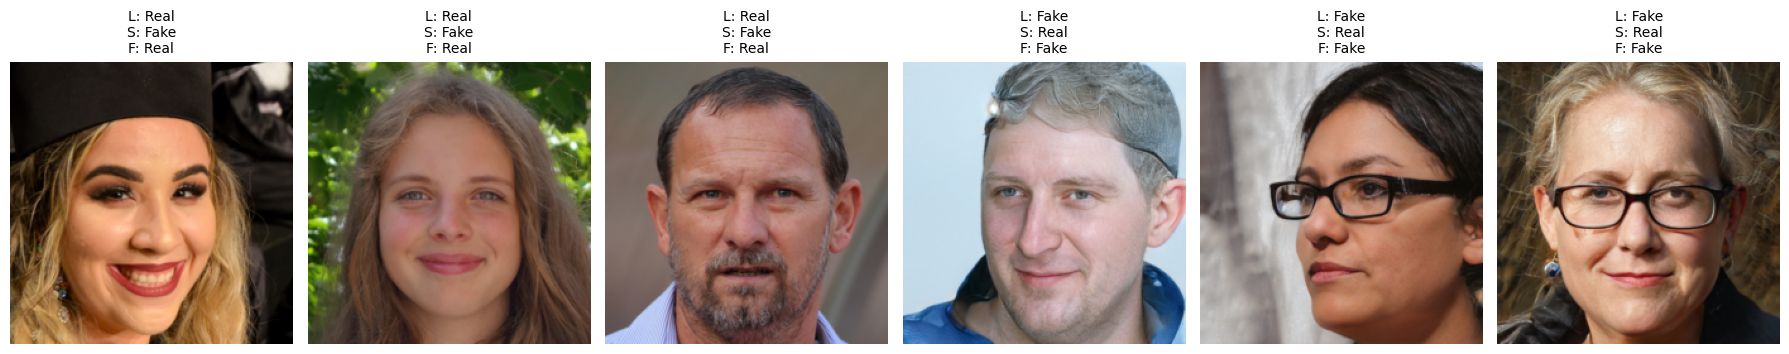

--- Finetune Wrong, Scratch Correct ---


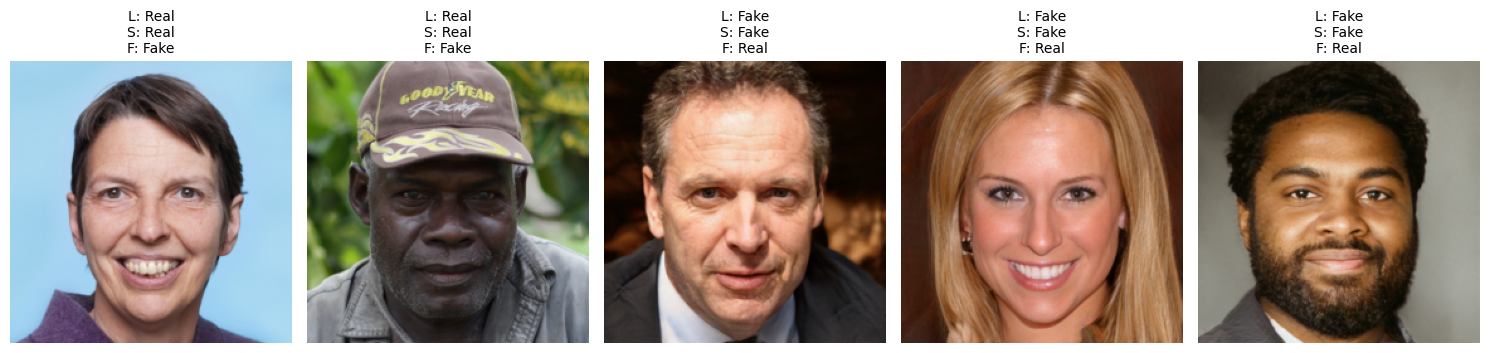

In [33]:
# --- Question 2: Visualization of Disagreements (Corrected) ---
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

# 1. Setup Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define Transforms (Must match training!)
# Transform for Scratch (No Normalization, just Resize)
transform_scratch = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Transform for Fine-Tune (ImageNet Normalization)
weights = models.ResNet18_Weights.IMAGENET1K_V1
transform_finetune = weights.transforms()

# 3. Load Datasets
# We need two loaders because the models expect different input transforms
test_set_scratch = torchvision.datasets.ImageFolder(root=os.path.join(DATA_PATH, 'test'), transform=transform_scratch)
test_loader_scratch = DataLoader(test_set_scratch, batch_size=1, shuffle=False)

test_set_finetune = torchvision.datasets.ImageFolder(root=os.path.join(DATA_PATH, 'test'), transform=transform_finetune)
test_loader_finetune = DataLoader(test_set_finetune, batch_size=1, shuffle=False)

# Get Class Names
class_names = test_set_scratch.classes
print(f"Dataset Classes: {class_names}")
class_map = {i: name for i, name in enumerate(class_names)}
print(f"Class Mapping: {class_map}")

# 4. Load Models
# Re-instantiate models to ensure clean state
model_scratch = ResNet18(pretrained=False, probing=False).to(device)
try:
    model_scratch.load_state_dict(torch.load('model_scratch_checkpoint.pth', map_location=device))
    print("Loaded model_scratch_checkpoint.pth")
except Exception as e:
    print(f"Error loading scratch checkpoint: {e}")

model_finetune = ResNet18(pretrained=True, probing=False).to(device)
try:
    model_finetune.load_state_dict(torch.load('model_finetune_checkpoint.pth', map_location=device))
    print("Loaded model_finetune_checkpoint.pth")
except Exception as e:
    print(f"Error loading finetune checkpoint: {e}")

model_scratch.eval()
model_finetune.eval()

# 5. Visualization Loop
# We want examples for each category, spread across both labels (0 and 1)
# Categories:
# A) Both Correct
# B) Both Wrong
# C) Finetune Correct, Scratch Wrong
# D) Finetune Wrong, Scratch Correct

categories = {
    "Both Correct": {0: [], 1: []},
    "Both Wrong": {0: [], 1: []},
    "Finetune Correct, Scratch Wrong": {0: [], 1: []},
    "Finetune Wrong, Scratch Correct": {0: [], 1: []}
}

required_per_label = 3  # Aim for 3 of each label per category (6 total per category)

print("Scanning test set for examples...")

with torch.no_grad():
    # Zip allows us to get the same image (different transform) for both models
    for (img_s, label_s), (img_f, label_f) in zip(test_loader_scratch, test_loader_finetune):
        
        # Move to device
        img_s = img_s.to(device)
        img_f = img_f.to(device)
        label = label_s.to(device) # Labels should be identical
        
        # Predict
        # Output dim is 1 (BCE), so we squeeze and threshold at 0
        pred_scratch = (model_scratch(img_s).squeeze() > 0).float()
        pred_finetune = (model_finetune(img_f).squeeze() > 0).float()
        
        label_val = int(label.item())
        p_s_val = int(pred_scratch.item())
        p_f_val = int(pred_finetune.item())
        
        params = {
            "img": img_s.cpu().squeeze(), # Use scratch image for plotting
            "label": label_val,
            "pred_scratch": p_s_val,
            "pred_finetune": p_f_val
        }
        
        cat_key = None
        if p_s_val == label_val and p_f_val == label_val:
            cat_key = "Both Correct"
        elif p_s_val != label_val and p_f_val != label_val:
            cat_key = "Both Wrong"
        elif p_f_val == label_val and p_s_val != label_val:
            cat_key = "Finetune Correct, Scratch Wrong"
        elif p_f_val != label_val and p_s_val == label_val:
            cat_key = "Finetune Wrong, Scratch Correct"
            
        if cat_key:
            # Add if we haven't filled this label quota yet
            if len(categories[cat_key][label_val]) < required_per_label:
                categories[cat_key][label_val].append(params)
                
        # Check completion: Are all buckets for all labels full?
        all_full = True
        for cat in categories:
            if len(categories[cat][0]) < required_per_label or len(categories[cat][1]) < required_per_label:
                all_full = False
                break
        if all_full:
            break

# 6. Plotting
def clean_label(name):
    """Helper to shorten class names"""
    return name.split('_')[-1].capitalize() if '_' in name else name

for cat_name, label_buckets in categories.items():
    # Combine samples from both labels
    samples = label_buckets[0] + label_buckets[1]
    
    if not samples:
        print(f"No samples found for category: {cat_name}")
        continue
        
    print(f"--- {cat_name} ---")
    num_samples = len(samples)
    plt.figure(figsize=(3 * num_samples, 4)) # Adjust width based on count
    
    for i, item in enumerate(samples):
        ax = plt.subplot(1, num_samples, i + 1)
        # Permute (C, H, W) -> (H, W, C) for Matplotlib
        img_plot = item["img"].permute(1, 2, 0).numpy()
        plt.imshow(img_plot)
        
        real_label = clean_label(class_names[item['label']])
        scratch_pred = clean_label(class_names[int(item['pred_scratch'])])
        finetune_pred = clean_label(class_names[int(item['pred_finetune'])])
        
        # Color code the titles
        L_color = 'black'
        S_color = 'green' if item['pred_scratch'] == item['label'] else 'red'
        F_color = 'green' if item['pred_finetune'] == item['label'] else 'red'
        
        title_text = f"L: {real_label}\nS: {scratch_pred}\nF: {finetune_pred}"
        ax.set_title(title_text, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()